<a href="https://colab.research.google.com/github/havaledar/6200/blob/main/A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 1 by AA

In [ ]:
###############################
#### DATA*6200 F22
#### Assignment 1
###############################

## reading in data
library(tidyverse)
foot <- read.csv("https://raw.githubusercontent.com/havaledar/6200/main/afferentData.csv", sep=",", skip=1, header=F)
colnames(foot) <- c("session","afferent", "subject", "sex", "age", "afferentClass","genloc","specloc",
                    "RFsize", "RFhardness","frequency","amplitude", "AvgInst", "peak3","impCycle")
foot <- data.frame(foot)

## identify missing values
# > rownames(foot)[(is.na(foot$impCycle))]
# [1] "474"
# foot[474,]

## remove them for this analysis
foot <- foot[-474,]

## pull out unique afferents and
## label unique afferents in database
Unique.aff <- distinct(foot, session, afferent, subject, afferentClass)
Unique.aff <- Unique.aff[order(Unique.aff$afferent, Unique.aff$subject, Unique.aff$afferentClass),]

## need (subject and afferent) to uniquely define an afferent
## create newID so only need one variable to identify afferent
foot$newID <- rep(0,nrow(foot))
for(i in 1:nrow(Unique.aff)){ 
  affid1 <- Unique.aff$subject[i]   # subsetting single afferent
  affid2 <- Unique.aff$afferent[i]
  foot$newID[foot$subject==affid1 & foot$afferent==affid2] <- i
}
## move new afferentID to just after original afferent ID
foot <- foot %>% relocate(newID, .after = afferent)

#################################################################
## Q1 staring descriptives...
#################################################################
## identify unique afferents by session, subject, afferent, class
##order columns with characters together and continuous together
uniqueAfferents <- foot[!duplicated(foot$newID), c(1:4,7,5,8:9,6,10:16)]

# cross-tabulate by subject and afferent class
afferentSummary <- table(uniqueAfferents$subject, uniqueAfferents$afferentClass)

# add row sums to count total number afferents per subject
afferentSummary <- cbind(afferentSummary, rowSums(afferentSummary))

# count number observations per subject, append to afferentSummary
numObs <- as.data.frame(foot %>% group_by(subject) %>% tally())
afferentSummary <- cbind(afferentSummary, numObs$n)
colnames(afferentSummary)[5:6] <- c("nafferents", "numObs")

# append column sums to tally number afferents by class, and total number obs
afferentSummary <- rbind(afferentSummary, colSums(afferentSummary))
rownames(afferentSummary)[length(rownames(afferentSummary))] <- "Totals"

nsessions <- length(unique(uniqueAfferents$session))
nsubjects <- apply(afferentSummary[-17,1:4],2, function(x){return(sum(x>0))})

#######################################
## Q2 table of demographic information#
#######################################

## using tables overall and then by afferent class, 
## use cbind to collate them into one table
sexSummary <- apply(table(uniqueAfferents$sex,uniqueAfferents$afferentClass),1,sum)
sexSummary <- cbind(sexSummary, round(addmargins(table(uniqueAfferents$sex,uniqueAfferents$afferentClass),2)/max(uniqueAfferents$newID),2))

genSummary <- apply(table(uniqueAfferents$genloc,uniqueAfferents$afferentClass),1,sum)
genSummary <- cbind(genSummary, round(addmargins(table(uniqueAfferents$genloc,uniqueAfferents$afferentClass),2)/max(uniqueAfferents$newID),2))

specSummary <- apply(table(uniqueAfferents$specloc,uniqueAfferents$afferentClass),1,sum)
specSummary <- cbind(specSummary, round(addmargins(table(uniqueAfferents$specloc,uniqueAfferents$afferentClass),2)/max(uniqueAfferents$newID),2))

## bind the rows of the demographic tables together
## to provide a single unified table
charSummary <- rbind(sexSummary, genSummary)
charSummary <- rbind(charSummary, specSummary)
charSummary <- rbind(charSummary, apply(sexSummary,2,sum))
colnames(charSummary)[1] <- "n"

## descriptives for continuous variables
## count number of missing values
var.list <- c("age", "RFsize", "RFhardness")
sapply(var.list, function(var){sum(is.na(uniqueAfferents[[var]]))})

## overall summaries and summaries by afferent class
## BUT need to filter table to remove NAs
## before calculating summary stats
## Also need to compute overall stats separate
## from afferent class specific stats
## and then bind the table togethe (rowwise)

## Age
all_ageSummary <- uniqueAfferents %>% 
  filter(!is.na(age)) %>% select(age) %>%
  summarise(afferentClass="overall", n=n(), mean=mean(age), stdev=sd(age), min=min(age), max=max(age))
ageSummary <- uniqueAfferents %>% group_by(afferentClass) %>% 
  filter(!is.na(age)) %>% select(age) %>%
  summarise(n=n(), mean=mean(age), stdev=sd(age), min=min(age), max=max(age))
ageSummary <- bind_rows(all_ageSummary, ageSummary)

## Receptive Field Size
all_rfsSummary <- uniqueAfferents %>% 
  filter(!is.na(RFsize)) %>% select(RFsize) %>%
  summarise(afferentClass="overall", n=n(), mean=mean(RFsize), stdev=sd(RFsize), min=min(RFsize), max=max(RFsize))
rfsSummary <- uniqueAfferents %>% group_by(afferentClass) %>% 
  filter(!is.na(RFsize)) %>% select(RFsize) %>%
  summarise(n=n(), mean=mean(RFsize), stdev=sd(RFsize), min=min(RFsize), max=max(RFsize))
rfsSummary <- bind_rows(all_rfsSummary, rfsSummary)

## Receptive Field Hardness
all_rfhSummary <- uniqueAfferents %>% 
  filter(!is.na(RFhardness)) %>% select(RFhardness) %>%
  summarise(afferentClass="overall", n=n(), mean=mean(RFhardness), stdev=sd(RFhardness), 
            min=min(RFhardness), max=max(RFhardness))
rfhSummary <- uniqueAfferents %>% group_by(afferentClass) %>% 
  filter(!is.na(RFhardness)) %>% select(RFhardness) %>%
  summarise(n=n(), mean=mean(RFhardness), stdev=sd(RFhardness), 
            min=min(RFhardness), max=max(RFhardness))
rfhSummary <- bind_rows(all_rfhSummary, rfhSummary)

## combine all quantitative variable stats together into one table
quantSummary <- bind_rows(ageSummary, rfsSummary, rfhSummary)


#########################################################
## Q3. Compute firing threshold and entrianment threshold
##     which differs for each afferent at each frequency
#########################################################

ft <- foot %>%   # firing threshold
  group_by(newID, frequency) %>%
  filter(impCycle > 0)  %>%
  summarise(firingThreshold = min(amplitude)) %>%
  ungroup()

ent <- foot %>%   # entrainment threshold
  group_by(newID, frequency) %>%
  filter(impCycle > 0.9)  %>%
  summarise(entrainThreshold = min(amplitude))%>%
  ungroup()

## merge it back with full data, first 
## firing threshold then entrainment threshold 
footJoined <- foot %>% left_join(ft, by=c("newID", "frequency")) %>%
                     left_join(ent, by=c("newID", "frequency")) 
dim(footJoined)
## footJoined now holds impCycle, firingThreshold and entrainThreshold
## overall summaries and summaries by afferent class
## using lapply() to go through the variable list
## first filter out NAs before calculating summary stats

# overall for impulses per cycle
var.list <- c("frequency", "amplitude", "impCycle")
allimpSummary <- lapply(var.list, function(x){
  footJoined %>% 
    filter(!is.na(.data[[x]])) %>% 
    summarise(afferentClass="overall", variable=x,n=n(), naff=n_distinct(newID), nsub=n_distinct(subject), mean=mean(.data[[x]]), stdev=sd(.data[[x]]), 
              min=min(.data[[x]]), med=median(.data[[x]]), max=max(.data[[x]]))
}) %>%
  bind_rows()

# impulses per cycle by afferent class 
impSummary <- lapply(var.list, function(x){
  footJoined %>% group_by(afferentClass) %>%
    filter(!is.na(.data[[x]])) %>% 
    summarise(variable=x,n=n(), naff=n_distinct(newID), nsub=n_distinct(subject), mean=mean(.data[[x]]), stdev=sd(.data[[x]]), 
              min=min(.data[[x]]), med=median(.data[[x]]), max=max(.data[[x]]))
}) %>%
  bind_rows()

# combine summaries into one table
impDescriptives <- allimpSummary %>% bind_rows(impSummary) %>%
  arrange(variable) 
  
# overall for firing threshold
var.list <- c("frequency", "amplitude")
allftSummary <- lapply(var.list, function(x){
  footJoined %>% 
    filter(!is.na(.data[[x]])) %>% 
    filter(firingThreshold==amplitude) %>%
    summarise(afferentClass="overall", variable=x, n=n(), naff=n_distinct(newID), nsub=n_distinct(subject), mean=mean(.data[[x]]), stdev=sd(.data[[x]]), 
              min=min(.data[[x]]), med=median(.data[[x]]), max=max(.data[[x]]))
}) %>%
  bind_rows()

# firing threshold by afferent class 
ftSummary <- lapply(var.list, function(x){
  footJoined %>% group_by(afferentClass) %>%
    filter(!is.na(.data[[x]])) %>% 
    filter(firingThreshold==amplitude) %>%
    summarise(variable=x,n=n(), naff=n_distinct(newID), nsub=n_distinct(subject), mean=mean(.data[[x]]), stdev=sd(.data[[x]]), 
              min=min(.data[[x]]), med=median(.data[[x]]), max=max(.data[[x]]))
}) %>%
  bind_rows()

# combine summaries into one table
ftDescriptives <- allftSummary %>% bind_rows(ftSummary) %>%
  arrange(variable) 

# overall for entrainment threshold
var.list <- c("frequency", "amplitude")
allentSummary <- lapply(var.list, function(x){
  footJoined %>% 
    filter(!is.na(.data[[x]])) %>%
    filter(entrainThreshold==amplitude) %>%
    summarise(afferentClass="overall", variable=x, n=n(), naff=n_distinct(newID), nsub=n_distinct(subject), mean=mean(.data[[x]]), stdev=sd(.data[[x]]), 
              min=min(.data[[x]]), med=median(.data[[x]]), max=max(.data[[x]]))
}) %>%
  bind_rows()

# entrainment threshold by afferent class 
entSummary <- lapply(var.list, function(x){
  footJoined %>% group_by(afferentClass) %>%
    filter(!is.na(.data[[x]])) %>% 
    filter(entrainThreshold==amplitude) %>%
    summarise(variable=x,n=n(), naff=n_distinct(newID), nsub=n_distinct(subject), mean=mean(.data[[x]]), stdev=sd(.data[[x]]), 
              min=min(.data[[x]]), med=median(.data[[x]]), max=max(.data[[x]]))
}) %>%
  bind_rows()

# combine summaries into one table
entDescriptives <- allentSummary %>% bind_rows(entSummary) %>%
  arrange(variable) 

age     RFsize RFhardness 
         0          1          3

Adding missing grouping variables: `afferentClass`
Adding missing grouping variables: `afferentClass`
Adding missing grouping variables: `afferentClass`
`summarise()` has grouped output by 'newID'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'newID'. You can override using the
`.groups` argument.


[1] 2703   18

#A2 by MH

#Question 1

## a

In [ ]:
#Plotting impulses per cycle, firing threshold, and entrainment thrsehold by afferent class

ggplot(data=subset(footJoined, !is.na(impCycle)), aes(afferentClass, impCycle)) + geom_boxplot() + xlab("Afferent class") + ylab("Impulses per cycle")
ggplot(data=subset(footJoined, !is.na(firingThreshold)), aes(afferentClass, firingThreshold)) + geom_boxplot() + xlab("Firing Threshold") + ylab("Impulses per cycle")
ggplot(data=subset(footJoined, !is.na(entrainThreshold)), aes(afferentClass, entrainThreshold)) + geom_boxplot() + xlab("Entrain Threshold") + ylab("Impulses per cycle")

##b

Warning message:
“Ignoring unknown parameters: firingThreshold.y”
No summary function supplied, defaulting to `mean_se()`

Warning message:
“Ignoring unknown parameters: firingThreshold.y”
No summary function supplied, defaulting to `mean_se()`



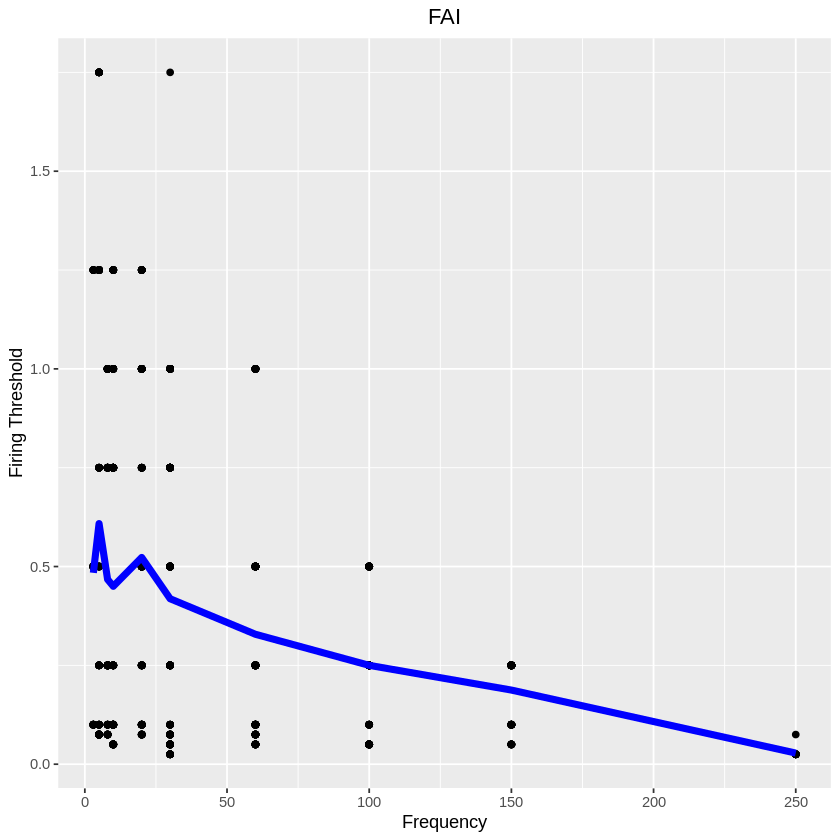

Warning message:
“Ignoring unknown parameters: firingThreshold.y”
No summary function supplied, defaulting to `mean_se()`



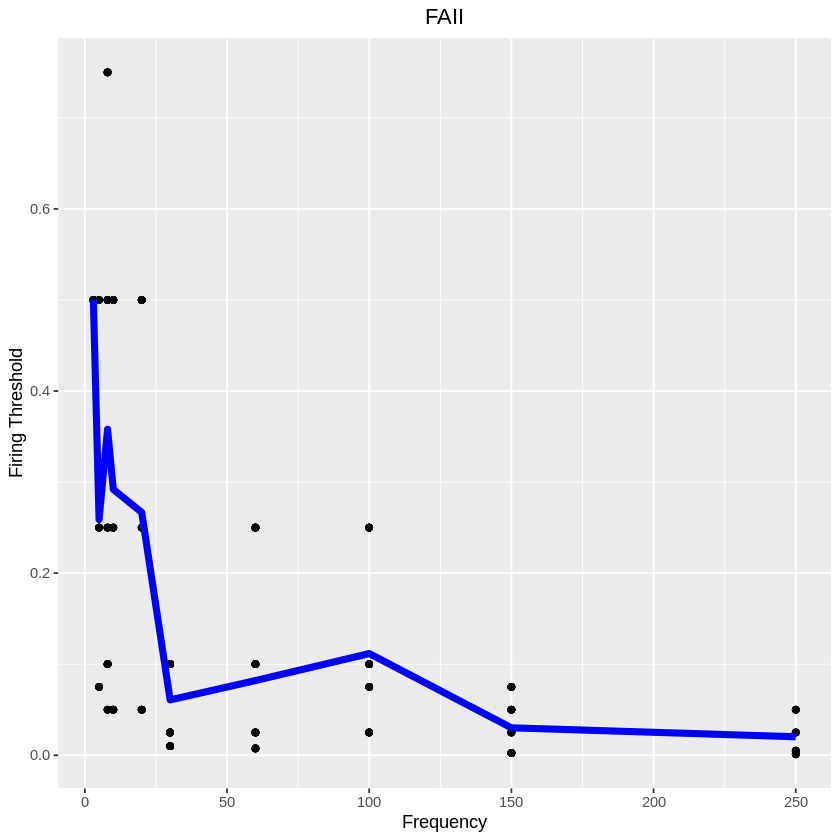

Warning message:
“Ignoring unknown parameters: firingThreshold.y”
No summary function supplied, defaulting to `mean_se()`



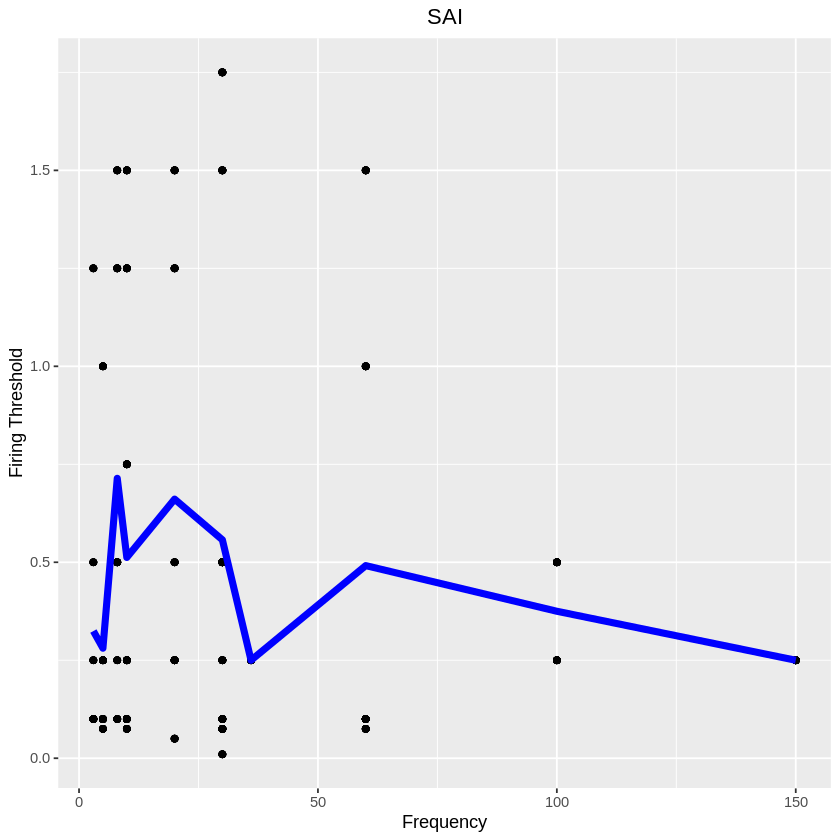

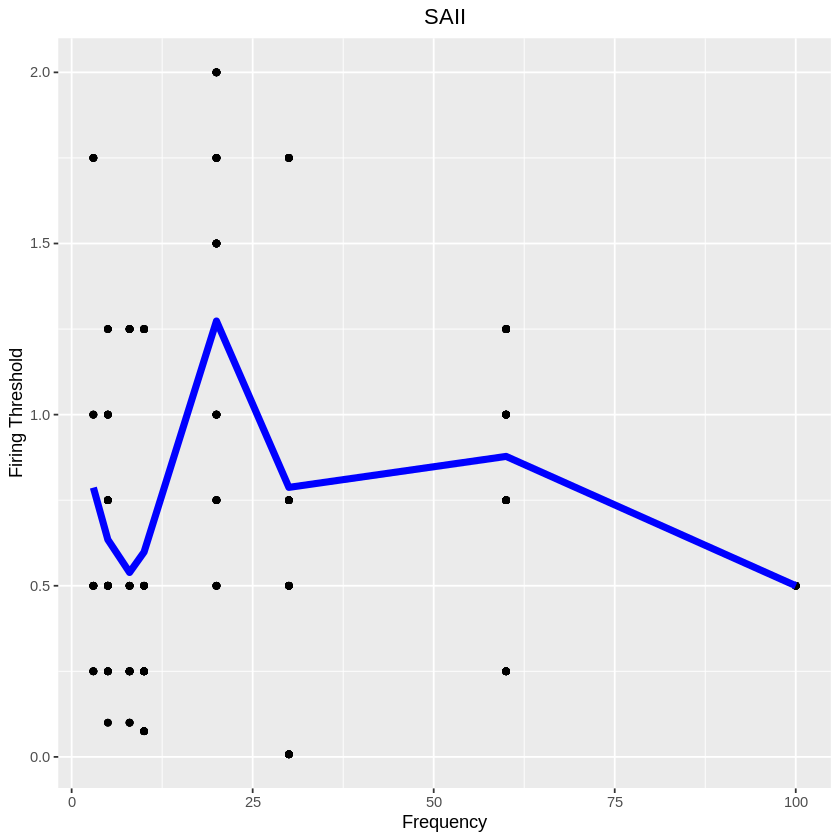

In [84]:
footJoined %>% 
filter(afferentClass=="FAI") %>% 
ggplot(aes(frequency, firingThreshold)) + geom_point() + ggtitle("FAI")+ xlab("Frequency") + ylab("Firing Threshold") +theme(plot.title = element_text(hjust = 0.5))+
stat_summary(firingThreshold.y=mean,geom="line", color="blue",lwd=2,aes(group=1))

footJoined %>% 
filter(afferentClass=="FAII") %>% 
ggplot(aes(frequency, firingThreshold)) + geom_point() + ggtitle("FAII")+ xlab("Frequency") + ylab("Firing Threshold") +theme(plot.title = element_text(hjust = 0.5))+
stat_summary(firingThreshold.y=mean,geom="line", color="blue",lwd=2,aes(group=1))

footJoined %>% 
filter(afferentClass=="SAI") %>% 
ggplot(aes(frequency, firingThreshold)) + geom_point() + ggtitle("SAI")+ xlab("Frequency") + ylab("Firing Threshold") +theme(plot.title = element_text(hjust = 0.5))+
stat_summary(firingThreshold.y=mean,geom="line", color="blue",lwd=2,aes(group=1))

footJoined %>% 
filter(afferentClass=="SAII") %>% 
ggplot(aes(frequency, firingThreshold)) + geom_point() + ggtitle("SAII")+ xlab("Frequency") + ylab("Firing Threshold") +theme(plot.title = element_text(hjust = 0.5))+
stat_summary(firingThreshold.y=mean,geom="line", color="blue",lwd=2,aes(group=1))

##c

Warning message:
“Ignoring unknown parameters: entrainThreshold.y”
Warning message:
“Removed 125 rows containing non-finite values (stat_summary).”
No summary function supplied, defaulting to `mean_se()`

Warning message:
“Removed 125 rows containing missing values (geom_point).”
Warning message:
“Ignoring unknown parameters: entrainThreshold.y”
Warning message:
“Removed 45 rows containing non-finite values (stat_summary).”
No summary function supplied, defaulting to `mean_se()`

Warning message:
“Removed 45 rows containing missing values (geom_point).”


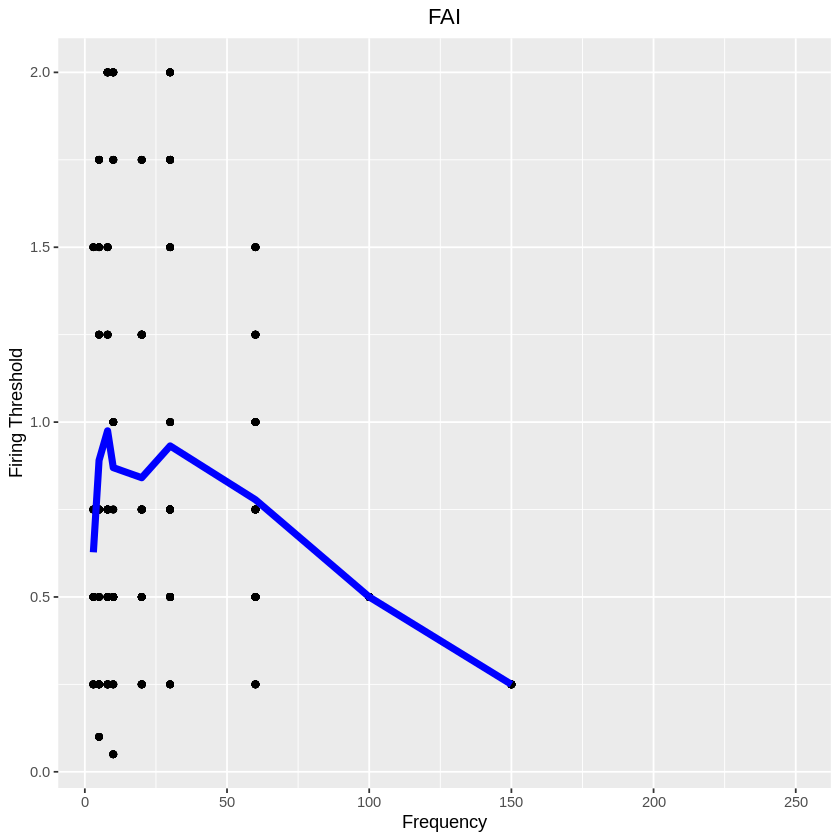

Warning message:
“Ignoring unknown parameters: entrainThreshold.y”
Warning message:
“Removed 192 rows containing non-finite values (stat_summary).”
No summary function supplied, defaulting to `mean_se()`

Warning message:
“Removed 192 rows containing missing values (geom_point).”


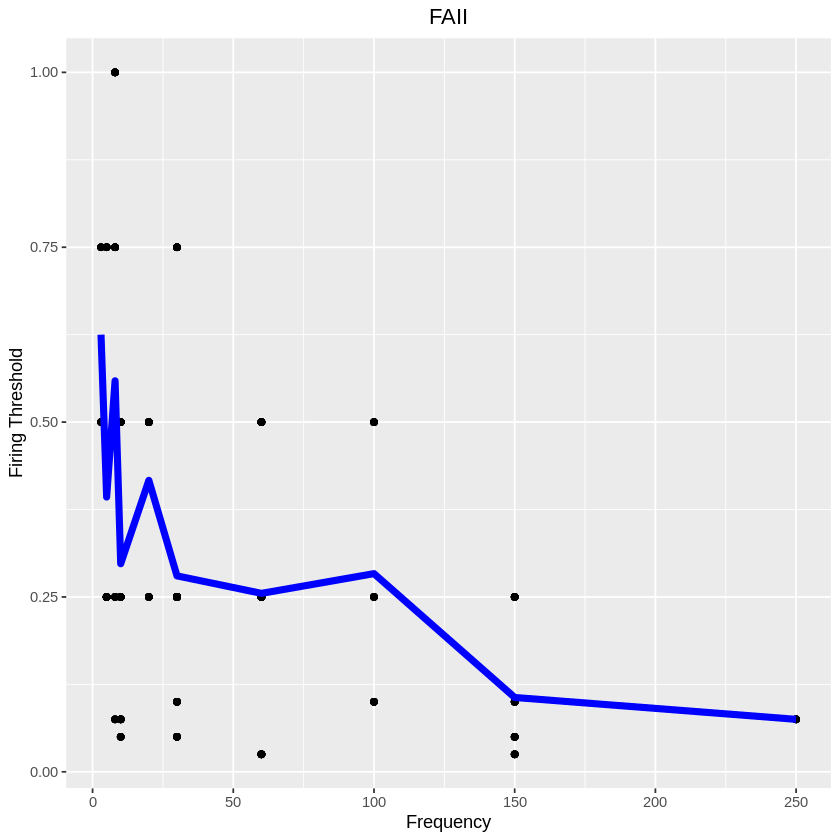

Warning message:
“Ignoring unknown parameters: entrainThreshold.y”
Warning message:
“Removed 201 rows containing non-finite values (stat_summary).”
No summary function supplied, defaulting to `mean_se()`

Warning message:
“Removed 201 rows containing missing values (geom_point).”


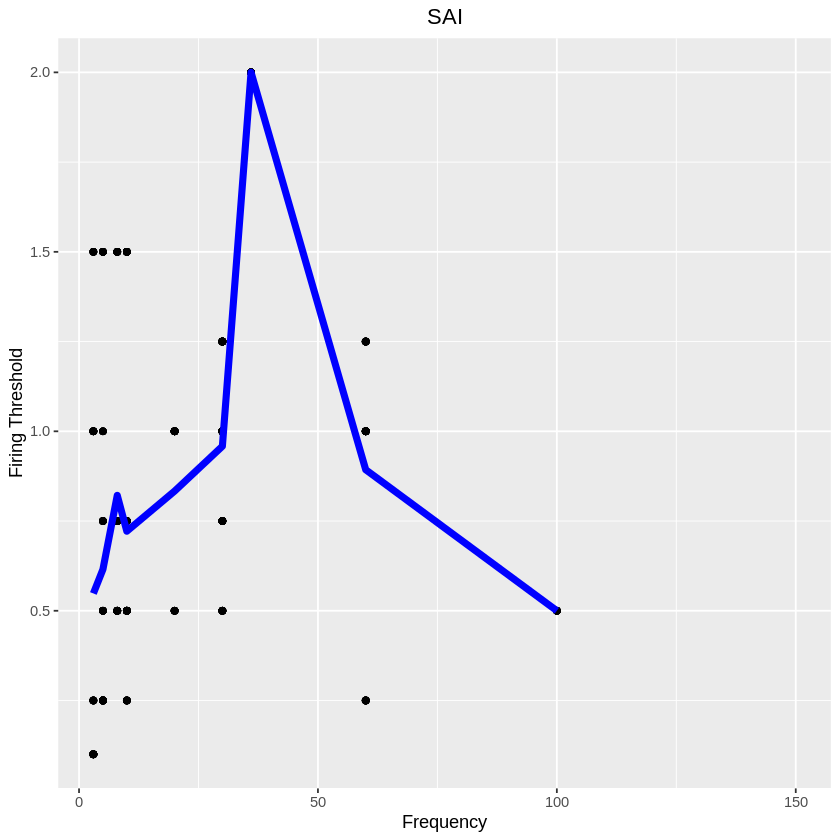

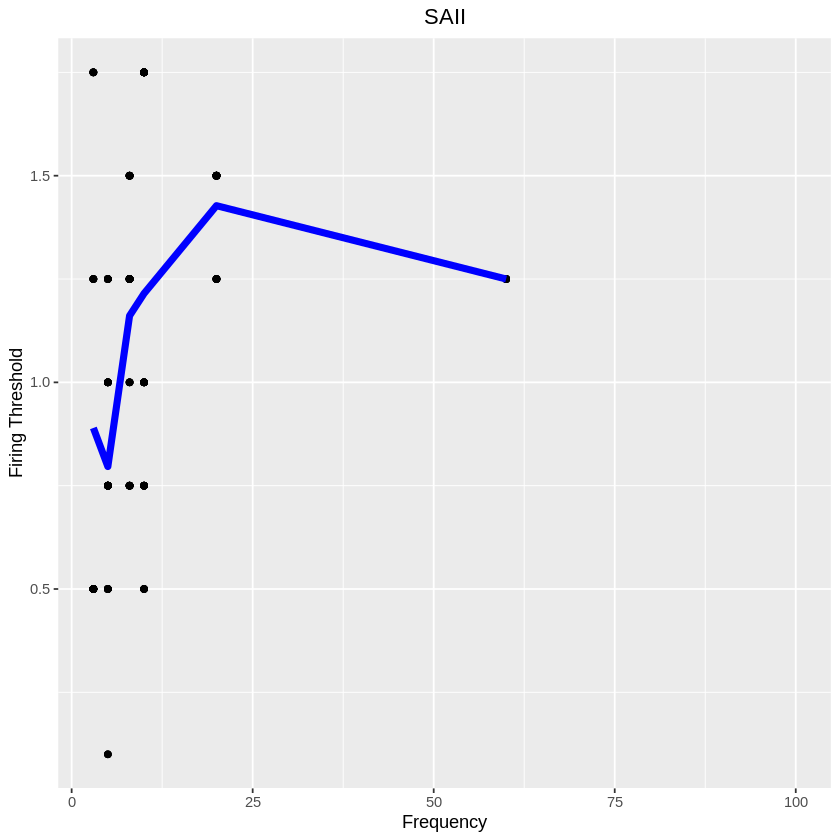

In [85]:
footJoined %>% 
filter(afferentClass=="FAI") %>% 
ggplot(aes(frequency, entrainThreshold)) + geom_point() + ggtitle("FAI")+ xlab("Frequency") + ylab("Firing Threshold") +theme(plot.title = element_text(hjust = 0.5))+
stat_summary(entrainThreshold.y=mean,geom="line", color="blue",lwd=2,aes(group=1))

footJoined %>% 
filter(afferentClass=="FAII") %>% 
ggplot(aes(frequency, entrainThreshold)) + geom_point() + ggtitle("FAII")+ xlab("Frequency") + ylab("Firing Threshold") +theme(plot.title = element_text(hjust = 0.5))+
stat_summary(entrainThreshold.y=mean,geom="line", color="blue",lwd=2,aes(group=1))

footJoined %>% 
filter(afferentClass=="SAI") %>% 
ggplot(aes(frequency, entrainThreshold)) + geom_point() + ggtitle("SAI")+ xlab("Frequency") + ylab("Firing Threshold") +theme(plot.title = element_text(hjust = 0.5))+
stat_summary(entrainThreshold.y=mean,geom="line", color="blue",lwd=2,aes(group=1))

footJoined %>% 
filter(afferentClass=="SAII") %>% 
ggplot(aes(frequency, entrainThreshold)) + geom_point() + ggtitle("SAII")+ xlab("Frequency") + ylab("Firing Threshold") +theme(plot.title = element_text(hjust = 0.5))+
stat_summary(entrainThreshold.y=mean,geom="line", color="blue",lwd=2,aes(group=1))

In [60]:
colnames(footJoined)

[1] "session"          "afferent"         "newID"            "subject"         
 [5] "sex"              "age"              "afferentClass"    "genloc"          
 [9] "specloc"          "RFsize"           "RFhardness"       "frequency"       
[13] "amplitude"        "AvgInst"          "peak3"            "impCycle"        
[17] "firingThreshold"  "entrainThreshold"